# `HFSAnomalyModel` Tutorial

Trey V. Wenger (c) December 2024

`HFSAnomalyModel` is like `HFSLTEModel`, but allows for non-LTE variations in hyperfine component optical depths, often called "hyperfine anomalies." This notebook demonstrates this model and is otherwise nearly identical to the `HFSLTEModel` notebook.

In [1]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+1.gc22da00.dirty


## `get_molecule_data`

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])

# molecular weight (number of protons)
weight_12CN = 12.0 + 14.0

dict_keys(['freq', 'Aul', 'degu', 'Eu', 'relative_int', 'log10_Q_terms'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]


## Simulating Data

1000


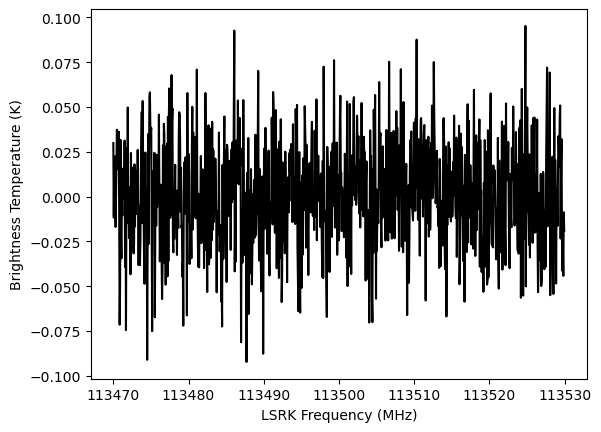

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.06) # MHz
# freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz
print(len(freq_axis))

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

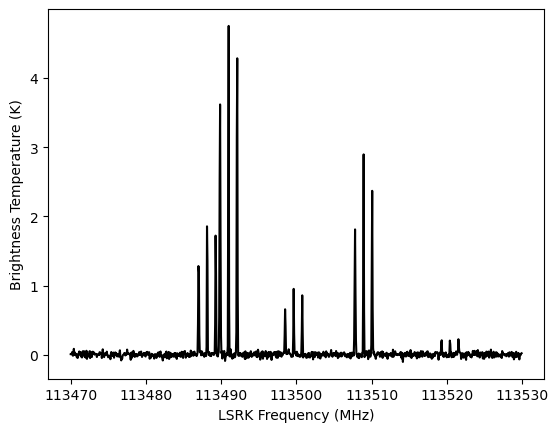

In [4]:
from bayes_cn_hfs import HFSAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = HFSAnomalyModel(
    dummy_data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    fix_tau_total = False, # do not assume tau_total
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

log10_anomaly = np.zeros((len(model.mol_data['freq']), n_clouds))
for i, freq in enumerate(model.mol_data['freq']):
    if freq == 113499.643:
        log10_anomaly[i] = -0.2
    elif freq == 113508.934:
        log10_anomaly[i] = 0.2

sim_brightness = model.model.observation.eval({
    "tau_total": [1.0, 2.0, 0.5],
    "log10_Tkin": [1.5, 1.25, 1.75],
    "velocity": [-3.0, 0.0, 3.0],
    "baseline_observation_norm": [0.0],
    "fwhm_L": 0.0,
    "log10_anomaly": log10_anomaly,
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

In [6]:
# Initialize and define the model
model = HFSAnomalyModel(
    data,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total = 1.0, # width of total optical depth prior
    prior_log10_Tkin = [1.5, 0.2], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = None, # do not include non-thermal broadening
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    fix_tau_total = False, # do not assume tau_total
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

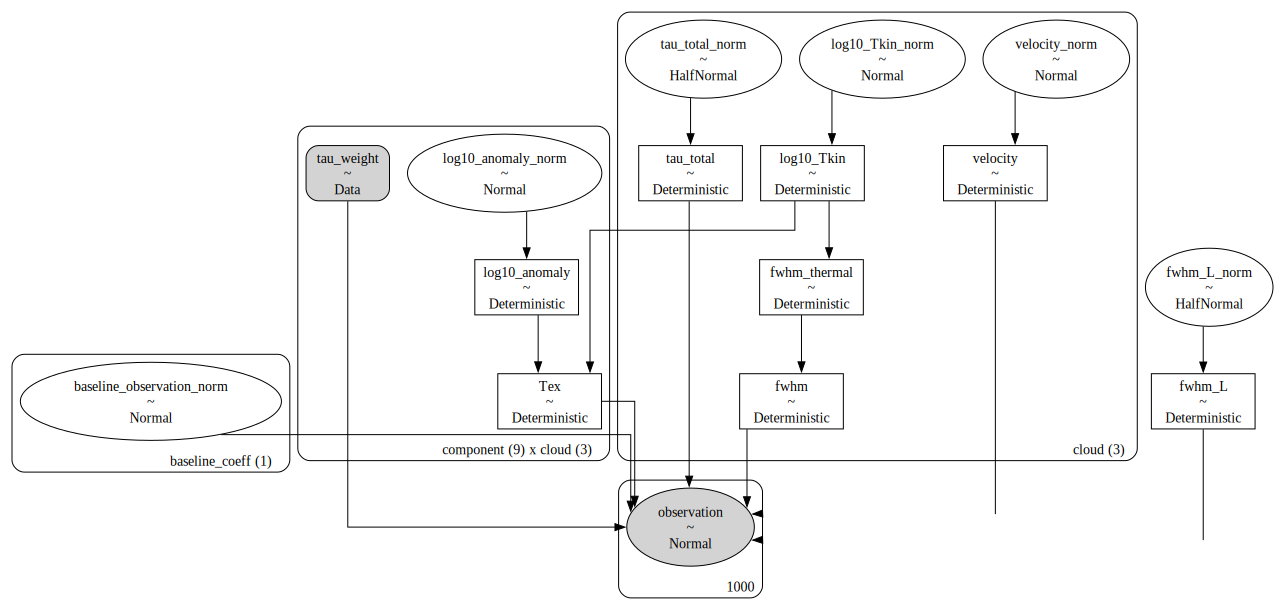

In [7]:
# Plot model graph
model.graph().render('hfs_anomaly_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, 1)
           tau_total_norm ~ HalfNormal(0, 1)
          log10_Tkin_norm ~ Normal(0, 1)
            velocity_norm ~ Normal(0, 1)
              fwhm_L_norm ~ HalfNormal(0, 1)
       log10_anomaly_norm ~ Normal(0, 1)
                tau_total ~ Deterministic(f(tau_total_norm))
               log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
                 velocity ~ Deterministic(f(velocity_norm))
             fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
                     fwhm ~ Deterministic(f(log10_Tkin_norm))
                   fwhm_L ~ Deterministic(f(fwhm_L_norm))
            log10_anomaly ~ Deterministic(f(log10_anomaly_norm))
                      Tex ~ Deterministic(f(log10_anomaly_norm, log10_Tkin_norm))
              observation ~ Normal(f(baseline_observation_norm, tau_total_norm, log10_anomaly_norm, log10_Tkin_norm, fwhm_L_norm, velocity_norm), <constant>)


Sampling: [baseline_observation_norm, fwhm_L_norm, log10_Tkin_norm, log10_anomaly_norm, observation, tau_total_norm, velocity_norm]


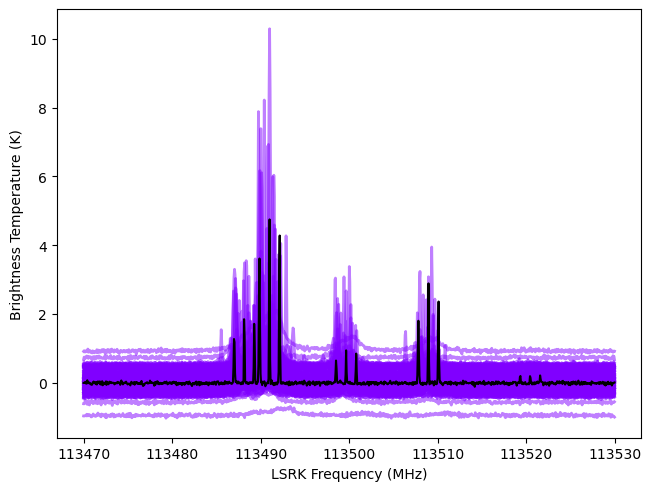

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = 33,403


Output()

Runtime: 1.13 minutes


In [11]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.162,0.003,-0.168,-0.156,0.000,0.000,764.0,650.0,NaN
log10_Tkin_norm[0],1.222,0.014,1.198,1.249,0.000,0.000,1085.0,981.0,NaN
log10_Tkin_norm[1],-1.195,0.011,-1.213,-1.172,0.000,0.000,1007.0,983.0,NaN
log10_Tkin_norm[2],-0.097,0.010,-0.115,-0.077,0.000,0.000,957.0,873.0,NaN
velocity_norm[0],1.000,0.001,0.999,1.001,0.000,0.000,725.0,714.0,NaN
velocity_norm[1],0.002,0.001,0.001,0.003,0.000,0.000,835.0,875.0,NaN
velocity_norm[2],-0.996,0.000,-0.997,-0.995,0.000,0.000,898.0,709.0,NaN
"log10_anomaly_norm[113123.3687, 0]",0.055,1.108,-2.081,2.026,0.034,0.024,1093.0,983.0,NaN
"log10_anomaly_norm[113123.3687, 1]",0.058,1.052,-1.905,1.964,0.034,0.025,946.0,835.0,NaN
"log10_anomaly_norm[113123.3687, 2]",0.034,1.111,-2.110,2.078,0.036,0.026,937.0,912.0,NaN


Sampling: [observation]


Output()

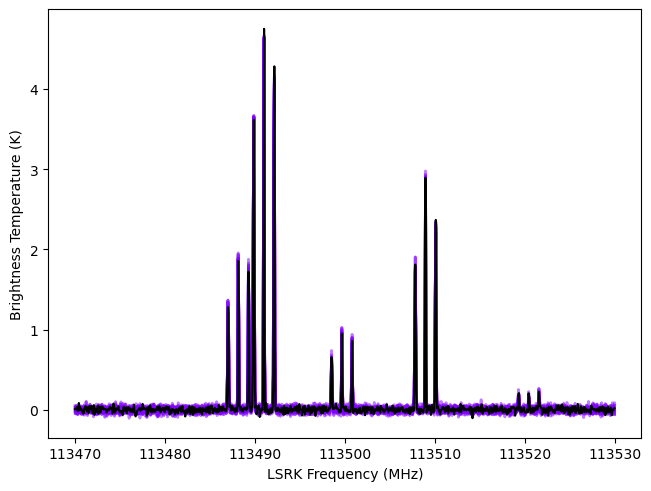

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.1, "abs_tolerance": 0.01, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
model.solve(kl_div_threshold=0.1)

In [ ]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.baseline_freeRVs + model.cloud_freeRVs + model.hyper_freeRVs)

In [ ]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.cloud_freeRVs if "log10_tex_comp" not in param]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [ ]:
var_names = [param for param in model.cloud_deterministics if "log10_tex_comp" not in param]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [ ]:
point_stats = az.summary(model.trace.solution_0, model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)